In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2  # We'll use ShuffleNetV2 via `keras_cv_attention_models`
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Install the library that supports ShuffleNetV2
!pip install --upgrade keras-cv-attention-models

from keras_cv_attention_models.shufflenetv2 import ShuffleNetV2


ModuleNotFoundError: No module named 'keras_cv_attention_models.shufflenetv2'

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Input, Add, DepthwiseConv2D, concatenate

def shuffle_unit(x, out_channels, bottleneck_ratio, strides):
    bottleneck_channels = int(out_channels * bottleneck_ratio)

    # Branch 1
    if strides == 2:
        x1 = DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding="same")(x)
        x1 = BatchNormalization()(x1)
        x1 = Conv2D(bottleneck_channels, kernel_size=(1, 1), strides=1, padding="same")(x1)
        x1 = BatchNormalization()(x1)
    else:
        x1 = x

    # Branch 2
    x2 = Conv2D(bottleneck_channels, kernel_size=(1, 1), strides=1, padding="same")(x)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)
    x2 = DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding="same")(x2)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(bottleneck_channels, kernel_size=(1, 1), strides=1, padding="same")(x2)
    x2 = BatchNormalization()(x2)
    x2 = ReLU()(x2)

    # Adjust channel dimensions if necessary
    if strides == 2:
        # Concatenate branches
        out = concatenate([x1, x2], axis=-1)
    else:
        # Add branches
        if x1.shape[-1] != x2.shape[-1]:
            x1 = Conv2D(x2.shape[-1], kernel_size=(1, 1), padding="same")(x1)
            x1 = BatchNormalization()(x1)
        out = Add()([x1, x2])

    return out


def ShuffleNetV2(input_shape=(224, 224, 3), num_classes=4, bottleneck_ratio=0.25):
    input_layer = Input(shape=input_shape)
    x = Conv2D(24, kernel_size=(3, 3), strides=2, padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(x)

    # ShuffleNet units
    for _ in range(4):
        x = shuffle_unit(x, out_channels=116, bottleneck_ratio=bottleneck_ratio, strides=1)
    for _ in range(8):
        x = shuffle_unit(x, out_channels=232, bottleneck_ratio=bottleneck_ratio, strides=2)
    for _ in range(4):
        x = shuffle_unit(x, out_channels=464, bottleneck_ratio=bottleneck_ratio, strides=1)

    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Define model
model = ShuffleNetV2(input_shape=(224, 224, 3), num_classes=4)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 24)   │            672 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 24)   │             96 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 112, 112, 24)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 24)     │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 29)     │            725 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 56, 56, 29)     │            116 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 56, 56, 29)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1        │ (None, 56, 56, 29)     │            290 │ re_lu_4[0][0]          │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 56, 56, 29)     │            116 │ depthwise_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 29)     │            870 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 56, 56, 29)     │            725 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 56, 56, 29)     │            116 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 56, 56, 29)     │            116 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 56, 56, 29)     │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 279,926 (1.07 MB)

 Trainable params: 270,946 (1.03 MB)

 Non-trainable params: 8,980 (35.08 KB)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [15]:
# Paths
dataset_dir = "/content/drive/My Drive/UnorganizedDataset1"  # Path to the dataset
output_dir = "output_data"  # Path to the split dataset

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio):
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        if len(images) < 3:
            print(f"Skipping '{class_name}' (not enough images for splitting).")
            continue

        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

        for split, split_images in zip(["train", "val", "test"], [train_images, val_images, test_images]):
            split_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            for img_path in split_images:
                shutil.copy(img_path, split_dir)

split_dataset(dataset_dir, output_dir, train_ratio, val_ratio, test_ratio)

print("Dataset has been successfully split into train, val, and test!")

# Paths
train_dir = "output_data/train"
val_dir = "output_data/val"
test_dir = "output_data/test"

# Parameters
img_size = (224, 224)  # Standard size for ShuffleNetV2
batch_size = 32
epochs = 20
learning_rate = 0.0001

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1,
)

# Save the trained model
model.save("coconut_shufflenetv2_model.h5")

Dataset has been successfully split into train, val, and test!
Found 2188 images belonging to 4 classes.
Found 470 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 233s 3s/step - accuracy: 0.9333 - loss: 0.1973 - val_accuracy: 0.9574 - val_loss: 0.1324
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.9352 - loss: 0.1776 - val_accuracy: 0.9617 - val_loss: 0.1049
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.9381 - loss: 0.1912 - val_accuracy: 0.9277 - val_loss: 0.2431
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9483 - loss: 0.1509 - val_accuracy: 0.9319 - val_loss: 0.1716
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9311 - loss: 0.1862 - val_accuracy: 0.9596 - val_loss: 0.1095
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9507 - loss: 0.1389 - val_accuracy: 0.9170 - val_loss: 0.2579
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9453 - loss: 0.1441 - val_accuracy: 0.9532 - val_loss: 0.1477
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9580 - loss: 0.1175 - val_accuracy: 0.9447 - val_loss: 0.

In [16]:
# Test the model (optional)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Found 471 images belonging to 4 classes.
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 924ms/step - accuracy: 0.9724 - loss: 0.0857
Validation Accuracy: 98.09%
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 969ms/step - accuracy: 0.9809 - loss: 0.0726
Test Accuracy: 98.09%


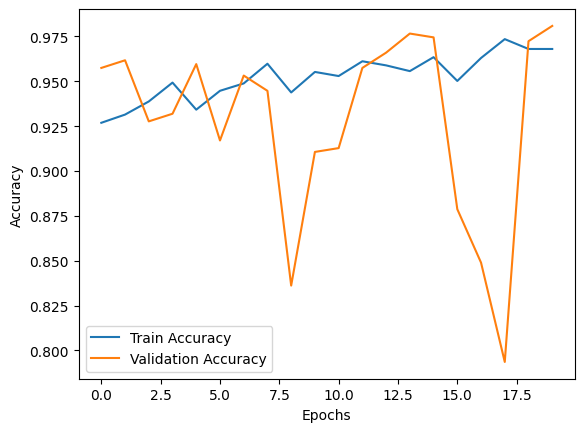

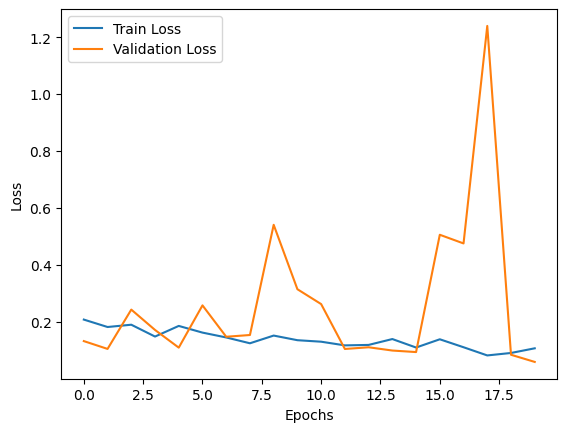

In [20]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:")
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 844ms/step
Confusion Matrix:
[[34 23 26 35]
 [27 39 30 18]
 [29 33 26 31]
 [31 20 35 34]]
Classification Report:
              precision    recall  f1-score   support

      Mature       0.28      0.29      0.28       118
  NonCoconut       0.34      0.34      0.34       114
         Old       0.22      0.22      0.22       119
       Young       0.29      0.28      0.29       120

    accuracy                           0.28       471
   macro avg       0.28      0.28      0.28       471
weighted avg       0.28      0.28      0.28       471



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


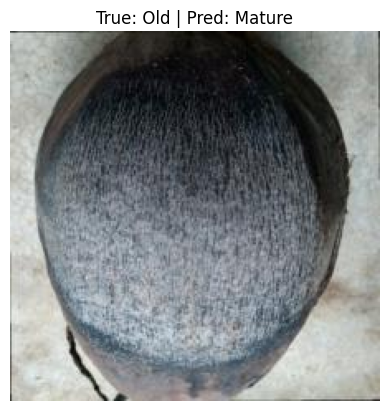

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


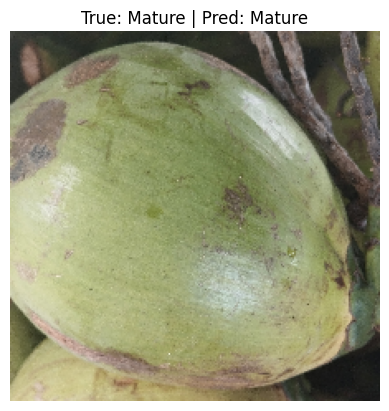

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


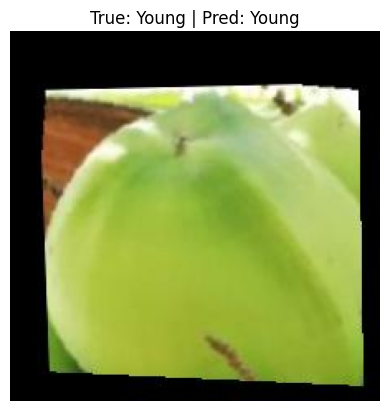

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


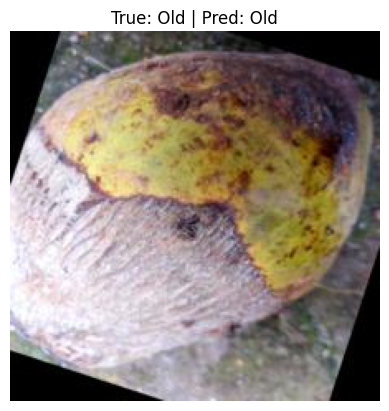

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


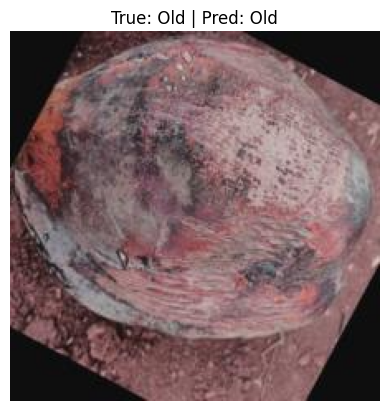

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


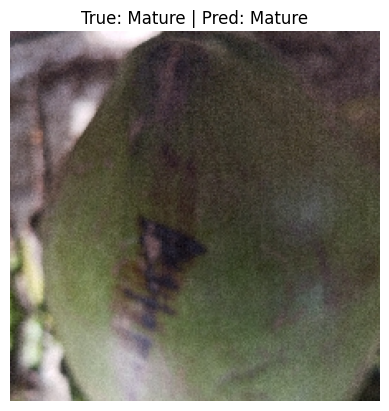

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


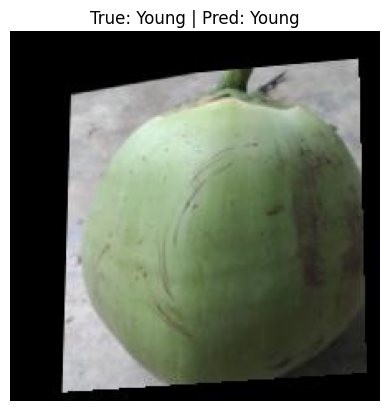

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


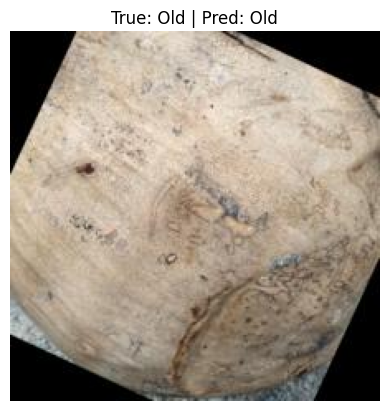

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


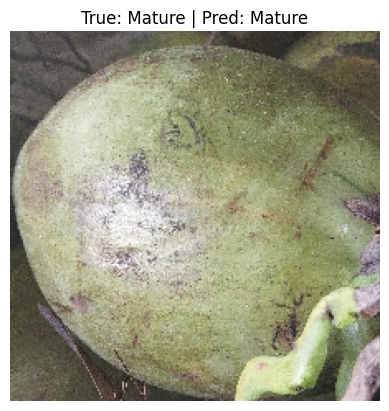

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


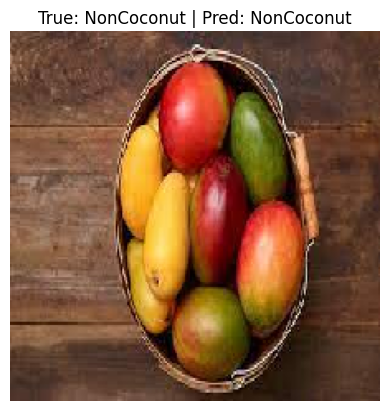

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Iterate over the test generator
for i, (img, label) in enumerate(test_generator):  # Unpack batches from the generator
    if i >= 10:  # Show only the first 10 test images
        break

    # Predict the class
    pred = model.predict(img)
    pred_label = class_labels[np.argmax(pred[0])]
    true_label = class_labels[np.argmax(label[0])]

    # Display the image
    plt.imshow(img[0])
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()
